
Problem 1
LDA Accuracy = 97.0
QDA Accuracy = 96.0


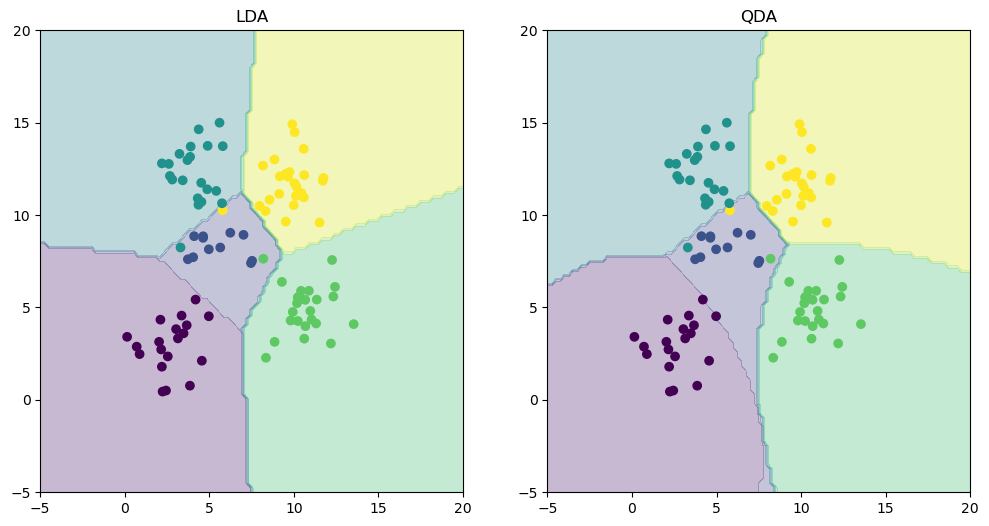


Problem 2
MSE without intercept on test data 106775.36145502607
MSE with intercept on test data3707.840180416822
MSE without intercept on train data19099.446844570855
MSE with intercept on train data2187.16029493039


NameError: name 'calculateL2Norm' is not defined

In [3]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys


def ldaLearn(X, y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix

    unique_labels = np.unique(y)
    num_classes = len(unique_labels)
    num_features = X.shape[1]
    class_means_matrix = np.zeros((num_classes, num_features))
    class_sample_counts = np.zeros(num_classes)
    for class_index, current_label in enumerate(unique_labels):
        samples_in_class = X[y.flatten() == current_label]
        class_means_matrix[class_index, :] = samples_in_class.mean(axis=0)
        class_sample_counts[class_index] = samples_in_class.shape[0]
    means = class_means_matrix.T
    covmat = np.cov(X.T)
    return means, covmat

def qdaLearn(X, y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes

    unique_classes = np.unique(y)
    num_features = X.shape[1]
    num_classes = unique_classes.shape[0]
    means = np.zeros((num_features, num_classes))
    covmats = []
    for idx, class_label in enumerate(unique_classes):
        class_samples = X[y.flatten() == class_label]
        class_mean = class_samples.mean(axis=0)
        means[:, idx] = class_mean
        class_covmat = np.cov(class_samples.T)
        covmats.append(class_covmat)
    return means, covmats


def ldaTest(means, covmat, Xtest, ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels
    
    num_classes = means.shape[1]
    num_features = means.shape[0]
    inv_covmat = np.linalg.inv(covmat)
    det_covmat = np.linalg.det(covmat)
    normalization_const = (2 * np.pi) ** (num_features / 2) * np.sqrt(det_covmat)
    ypred = []
    for x in Xtest:
        pdfs = []
        for class_idx in range(num_classes):
            corrected_mean = x - means[:, class_idx]
            exponent = -0.5 * np.dot(np.dot(corrected_mean, inv_covmat), corrected_mean.T)
            likelihood = np.exp(exponent) / normalization_const
            pdfs.append(likelihood)
        predicted_class = np.argmax(pdfs) + 1
        ypred.append(predicted_class)
    ypred = np.array(ypred).reshape(-1, 1)
    acc = np.mean(ypred == ytest) * 100
    return acc, ypred
    


def qdaTest(means, covmats, Xtest, ytest):
    # Inputs:
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs:
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels
    
    num_classes = means.shape[1]
    num_features = means.shape[0]
    ypred = []
    inv_covmats = [np.linalg.inv(covmat) for covmat in covmats]
    det_covmats = [np.linalg.det(covmat) for covmat in covmats]
    for x in Xtest:
        pdfs = []
        for class_idx in range(num_classes):
            corrected_mean = x - means[:, class_idx]
            exponent = -0.5 * np.dot(np.dot(corrected_mean, inv_covmats[class_idx]), corrected_mean.T)
            normalization_const = (2 * np.pi) ** (num_features / 2) * np.sqrt(det_covmats[class_idx])
            likelihood = np.exp(exponent) / normalization_const
            pdfs.append(likelihood)
        predicted_class = np.argmax(pdfs) + 1
        ypred.append(predicted_class)
    ypred = np.array(ypred).reshape(-1, 1)
    acc = np.mean(ypred == ytest) * 100
    return acc, ypred


def learnOLERegression(X, y):
    # Inputs:
    # X = N x d
    # y = N x 1
    # Output:
    # w = d x 1
    
    X_transpose = np.transpose(X)
    X_transpose_X = np.dot(X_transpose, X)
    X_transpose_y = np.dot(X_transpose, y)
    w = np.dot(np.linalg.inv(X_transpose_X), X_transpose_y)
    return w


def learnRidgeRegression(X, y, lambd):
    # Inputs:
    # X = N x d
    # y = N x 1
    # lambd = ridge parameter (scalar)
    # Output:
    # w = d x 1

    X_transpose_X = np.dot(X.T, X)
    lambda_identity = lambd * np.identity(X.shape[1])
    matrix = lambda_identity + X_transpose_X
    inverse_matrix = np.linalg.inv(matrix)
    w = np.dot(inverse_matrix, np.dot(X.T, y))
    return w

def testOLERegression(w, Xtest, ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse

    residuals = ytest - np.dot(Xtest, w)
    mse = np.mean(np.square(residuals))
    return mse

def regressionObjVal(w, X, y, lambd):
    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda

    w_reshaped = np.reshape(w, (w.size, 1))
    error = (np.sum(np.square(y - np.dot(X, w_reshaped)) / 2)) + ((lambd * np.dot(w_reshaped.T, w_reshaped)) / 2)
    error_grad = (-1.0 * np.dot(y.T, X)) + np.dot(np.dot(w_reshaped.T, X.T), X) + (lambd * w_reshaped.T)
    return error.flatten(), error_grad.flatten()


def mapNonLinear(x, p):
    # Inputs:
    # x - a single column vector (N x 1)
    # p - integer (>= 0)
    # Outputs:
    # Xp - (N x (p+1))

    Xp = np.ones((x.shape[0], 1))
    x = np.reshape(x, (x.shape[0], 1))
    for power in range(1, p + 1):
        term = np.array(x ** power)
        Xp = np.concatenate((Xp, term), axis=1)
    return Xp


#For Comparing weights
def computeL2Norm(weight): 
    l2Norm = 0.0
    for i in range(0, weight.shape[0]):
        l2Norm += weight[i] ** 2
    return l2Norm


# Main script

# Problem 1
print('\nProblem 1') 
#load the sample data
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))
# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest)
plt.title('LDA')
plt.subplot(1, 2, 2)


zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest)
plt.title('QDA')

plt.show()

#Problem 2
print('\nProblem 2') 
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)


w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print('MSE without intercept on test data '+str(mle))
print('MSE with intercept on test data'+str(mle_i))

#The same thing, except testing on train data
mle = testOLERegression(w,X,y)
mle_i = testOLERegression(w_i,X_i,y)

print('MSE without intercept on train data'+str(mle))
print('MSE with intercept on train data'+str(mle_i))

print('L2 Norm for OLS Regression (using weights and intercepts on test data):',calculateL2Norm(w_i))


#Problem 3
print('\nProblem 3')
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
#train
min_w_map_train = sys.maxsize
min_lambda_train = 0.0
#test
min_w_map_test = sys.maxsize
min_lambda_test = 0.0
min_lambda_w = None

for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)

    if(mses3_train[i]<min_w_map_train):
        min_w_map_train = mses3_train[i]
        min_lambda_train = lambd
    if(mses3[i]<min_w_map_test):
        min_w_map_test = mses3[i]
        min_lambda_test = lambd
        min_lambda_test_index = i
        min_lambda_w = w_l

    i = i + 1

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.xlabel('Lambda')
plt.ylabel('MSE')

print('(Train):Minimum MSE:', min_w_map_train, ' at lambda:', min_lambda_train)
print('(Test):Minimum MSE:', min_w_map_test, ' at lambda:', min_lambda_test)    
plt.show()

#Print l2 for min lambda (test)
print('L2 Norm for Ridge Regression (using weights corresponding to minimum lambda on test data):',calculateL2Norm(min_lambda_w))


# Problem 4
print('\nProblem 4')
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 70}    # Preferred value.
w_init = np.ones(X_i.shape[1])  # One-dimensional array
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
print("Min MSE4 train :" , np.amin(mses4_train))
print("Min MSE4 test :" , np.amin(mses4))
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.xlabel('Lambda')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.xlabel('Lambda')
plt.ylabel('MSE')

plt.show()

# Problem 5
print('\nProblem 5')
pmax = 7
lambda_opt = min_lambda_test # REPLACE THIS WITH lambda_opt estimated from Problem 3
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.xlabel('Degree of polynomial')
plt.ylabel('MSE')

plt.legend(('No Regularization','Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)

plt.title('MSE for Test Data')
plt.legend(('No Regularization','Regularization'))
plt.xlabel('Degree of polynomial')
plt.ylabel('MSE')
plt.show()

#find min MSE for train data
print('(Problem 5) Minimum MSE for test data',np.amin(mses5))
print('(Problem 5) Minimum MSE for train data',np.amin(mses5_train))
